In [187]:
# All imports in one place

import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
from collections import Counter
from google.colab import drive
from sklearn.decomposition import PCA

In [188]:
# Reading files

drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/My Drive/project_files/train_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
# Using gensim library simple preprocessing

review_prepro = df_train['reviewText'].apply(gensim.utils.simple_preprocess)

In [193]:
# Definig a word2vec model

model = gensim.models.Word2Vec(
    window = 10,
    min_count = 2,
    workers = 4
)

In [194]:
# Building Vocabulary

model.build_vocab(review_prepro)

In [195]:
# Training the Word2Vec model

model.train(
    review_prepro,
    total_examples = model.corpus_count,
    epochs = model.epochs
)

(345179751, 452579780)

In [196]:
# Printing the most similar words for each keyword

print(model.wv.most_similar('warranty'))
print(model.wv.most_similar('guarantee'))

[('warrantee', 0.9023738503456116),
 ('warrenty', 0.880789577960968),
 ('warranties', 0.8291723728179932),
 ('warrantied', 0.7214640974998474),
 ('guarantee', 0.7158631086349487),
 ('warantee', 0.6900702118873596),
 ('squaretrade', 0.6870704889297485),
 ('assurant', 0.663602352142334),
 ('waranty', 0.6440156102180481),
 ('contract', 0.6427466869354248)]

In [197]:
# Adding keywords to relevant words

keywords = ['guarantee','warranty']
relevent_words = set(keywords)

# Adding most similar words to relevant words

for word in keywords:
  similar_words = model.wv.most_similar(word, topn = 20)
  for i in similar_words:
    relevent_words.add(i[0])

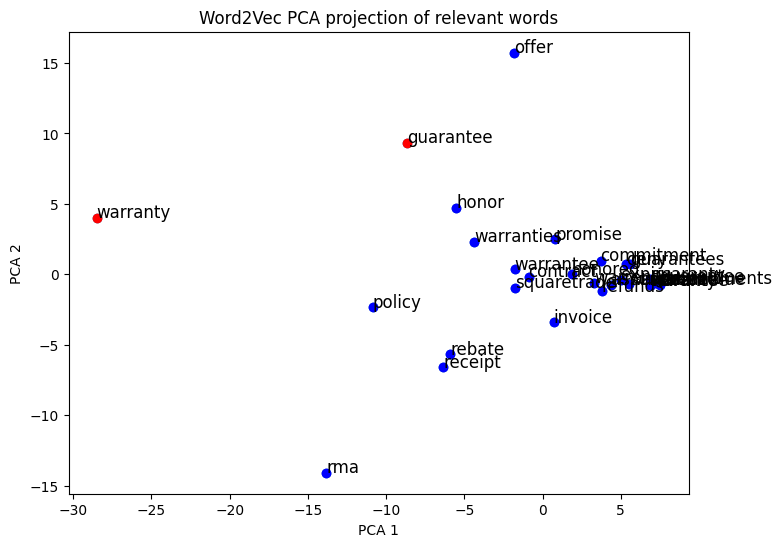

In [198]:
valid_words = [word for word in relevent_words if word in model.wv]


vectors = [model.wv[word] for word in valid_words]

pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

plt.figure(figsize=(8,6))
plt.scatter(result[:,0], result[:,1])

for i, word in enumerate(valid_words):
    color = 'red' if word in ['guarantee', 'warranty'] else 'blue'
    plt.scatter(result[i,0], result[i,1], color=color)
    plt.annotate(word, xy=(result[i,0], result[i,1]), fontsize=12)

plt.title("Word2Vec PCA projection of relevant words")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


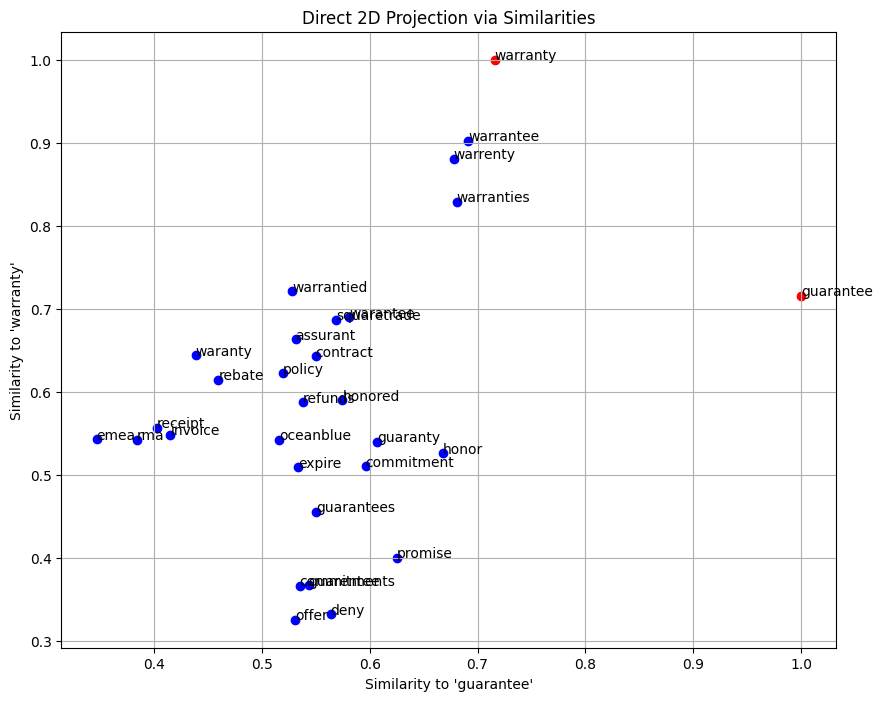

In [199]:
x_vals = [model.wv.similarity(word, 'guarantee') for word in valid_words]
y_vals = [model.wv.similarity(word, 'warranty') for word in valid_words]

plt.figure(figsize=(10,8))
for i, word in enumerate(valid_words):
    color = 'red' if word in ['guarantee', 'warranty'] else 'blue'
    plt.scatter(x_vals[i], y_vals[i], color=color)
    plt.annotate(word, (x_vals[i], y_vals[i]), fontsize=10)
plt.xlabel("Similarity to 'guarantee'")
plt.ylabel("Similarity to 'warranty'")
plt.title("Direct 2D Projection via Similarities")
plt.grid(True)
plt.show()

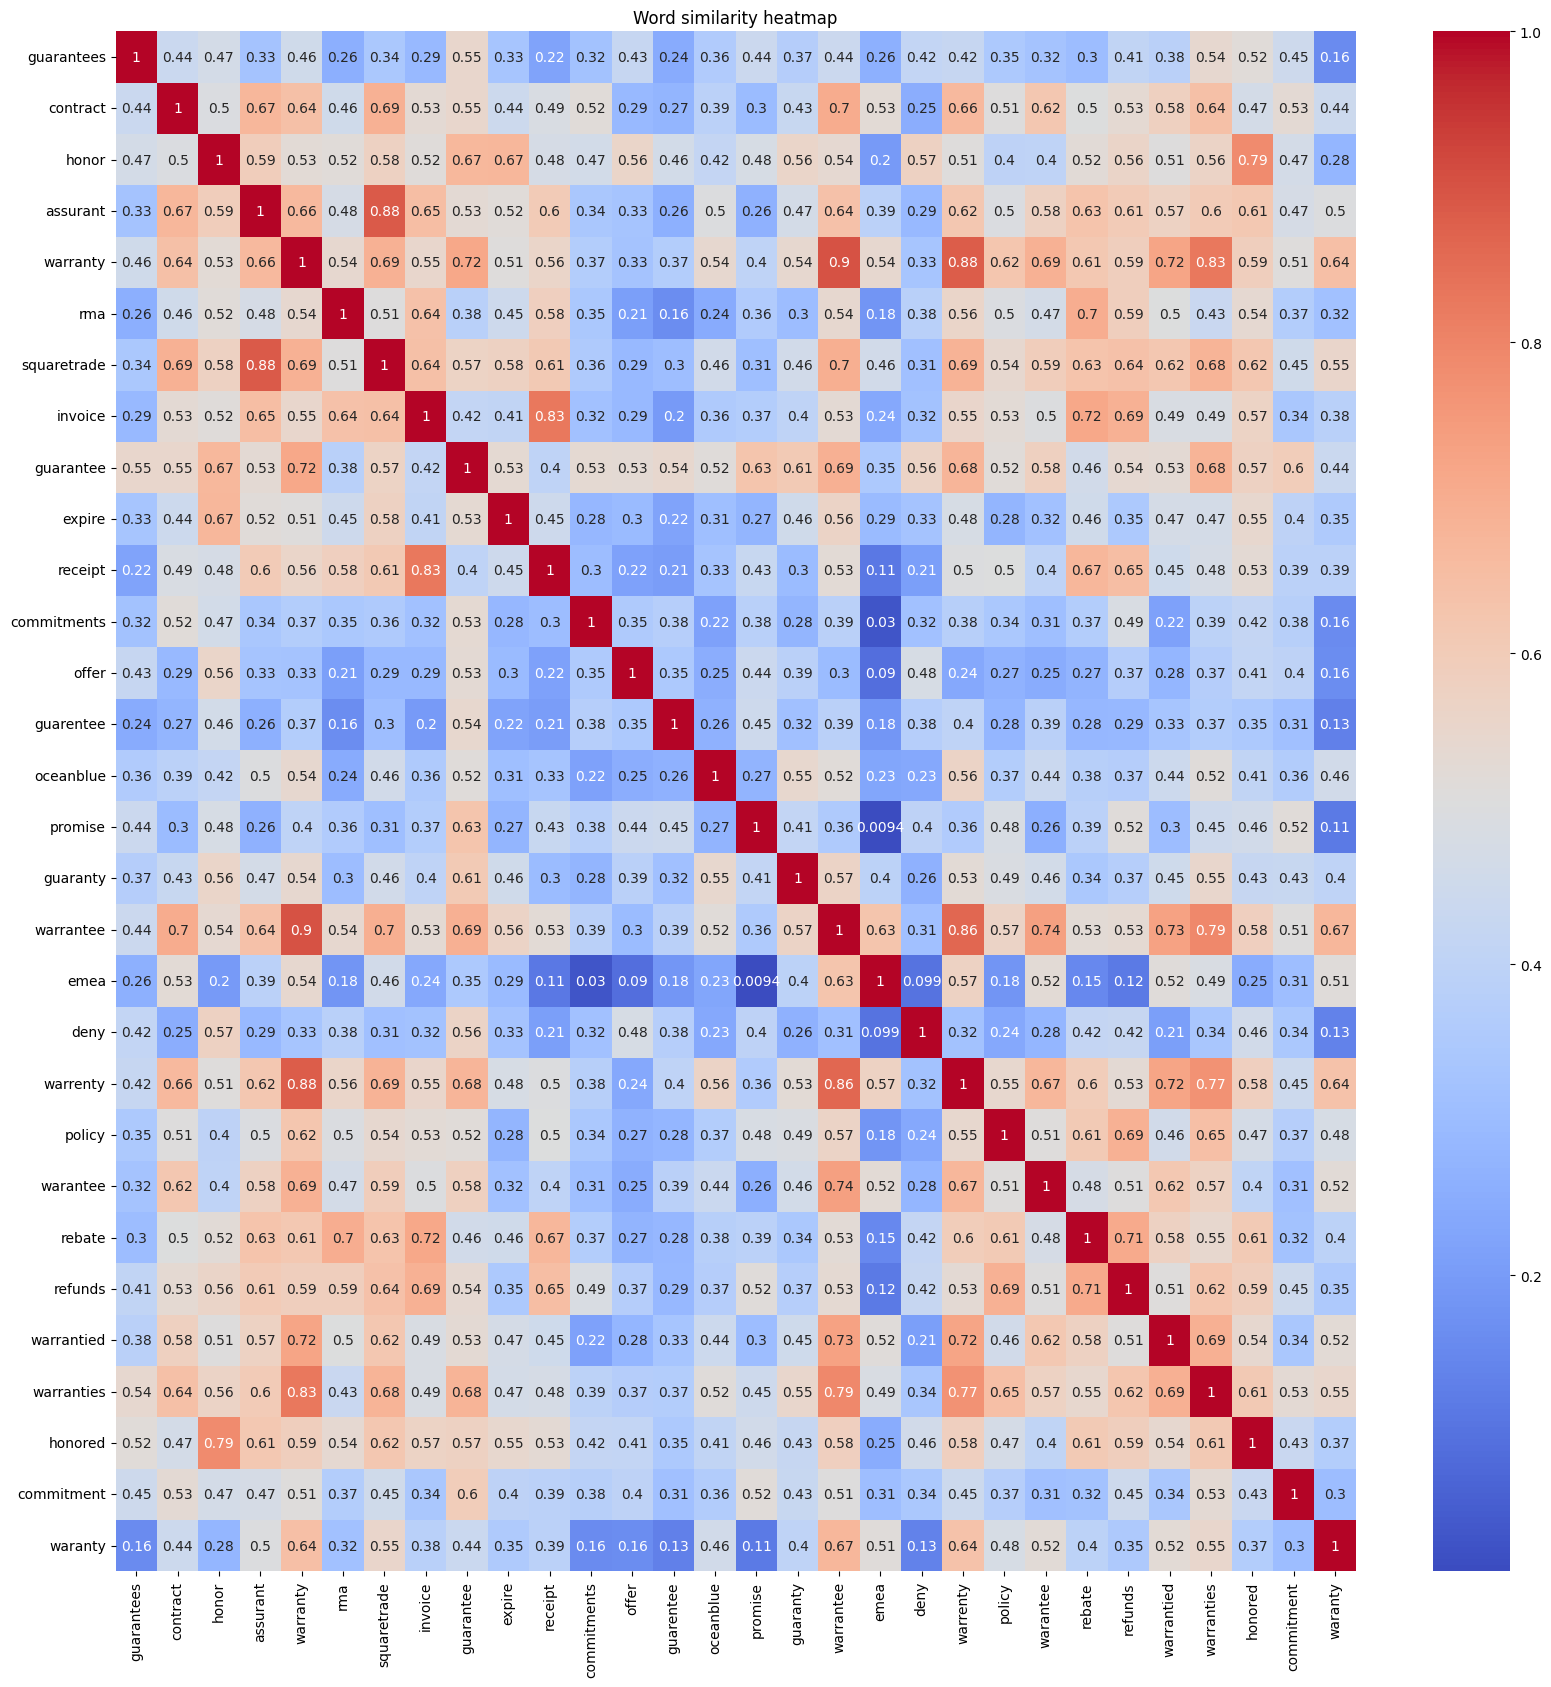

In [200]:
words = list(relevent_words)
data = []

for w1 in words:
    row = []
    for w2 in words:
        row.append(model.wv.similarity(w1, w2))
    data.append(row)

df = pd.DataFrame(data, columns=words, index=words)

plt.figure(figsize=(20,20))
sns.heatmap(df, annot=True, cmap='coolwarm')
plt.title("Word similarity heatmap")
plt.show()

/tmp/ipython-input-201-4087978129.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="Blues_d")


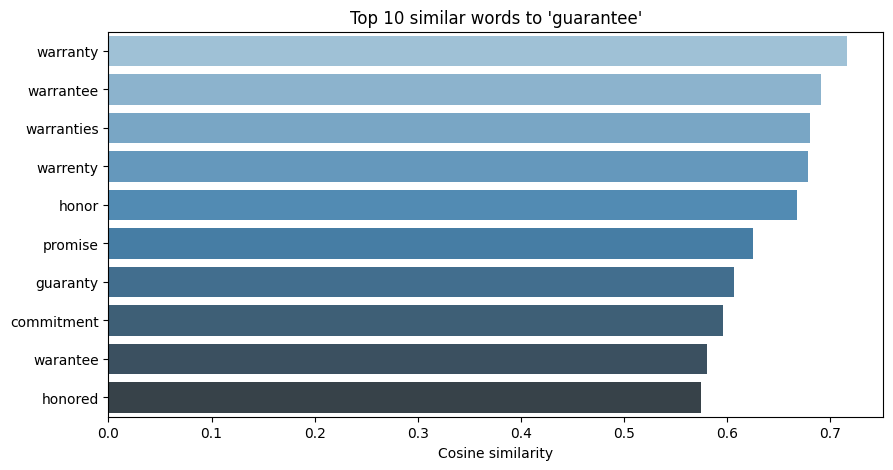

In [201]:
nearest = model.wv.most_similar('guarantee', topn=10)
words, scores = zip(*nearest)

plt.figure(figsize=(10,5))
sns.barplot(x=scores, y=words, palette="Blues_d")
plt.title("Top 10 similar words to 'guarantee'")
plt.xlabel("Cosine similarity")
plt.show()

/tmp/ipython-input-202-774810049.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="Blues_d")


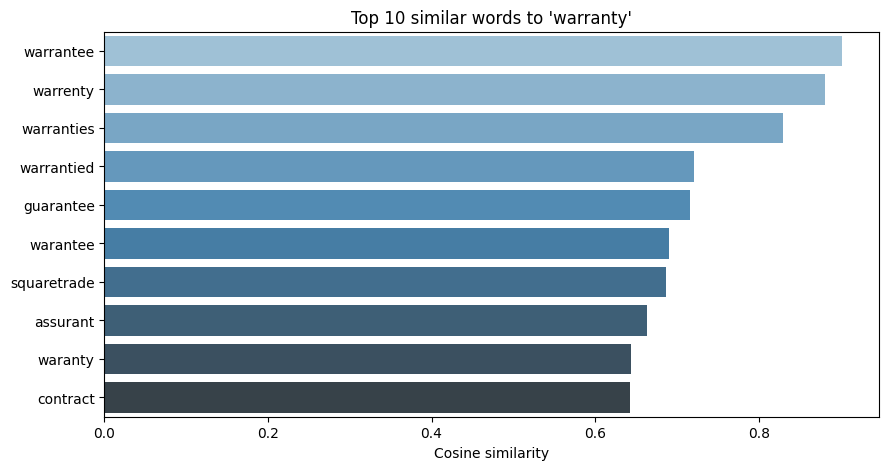

In [202]:
nearest = model.wv.most_similar('warranty', topn=10)
words, scores = zip(*nearest)

plt.figure(figsize=(10,5))
sns.barplot(x=scores, y=words, palette="Blues_d")
plt.title("Top 10 similar words to 'warranty'")
plt.xlabel("Cosine similarity")
plt.show()

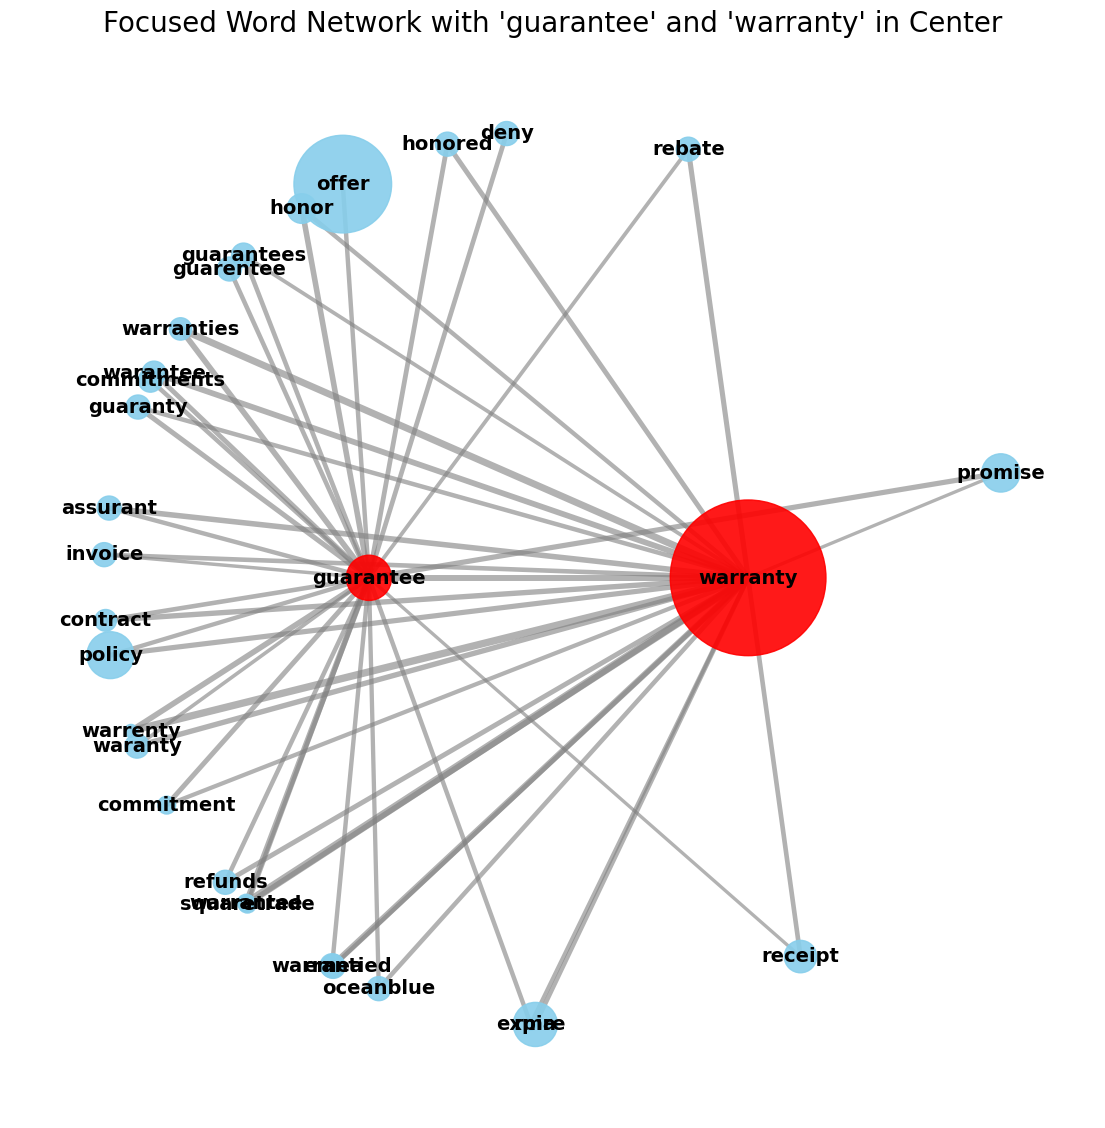

In [203]:
focus_words = ['guarantee', 'warranty']
G = nx.Graph()

threshold = 0.4

for word in valid_words:
    for fw in focus_words:
        if word != fw:
            sim = model.wv.similarity(word, fw)
            if sim > threshold:
                G.add_node(word)
                G.add_edge(word, fw, weight=sim)

for fw in focus_words:
    if fw not in G.nodes():
        G.add_node(fw)

pos = nx.spring_layout(G, k=0.8, iterations=200, seed=42)


pos['guarantee'] = np.array([0, 0])
pos['warranty'] = np.array([1, 0])


for node in G.nodes():
    if node not in focus_words:
        direction = pos[node] - np.array([0.5, 0])
        pos[node] = np.array([0.5, 0]) + direction / np.linalg.norm(direction) * 1.2

node_colors = ['red' if node in focus_words else 'skyblue' for node in G.nodes()]

node_sizes = [word_counts.get(node, 10)*5 if node in word_counts else 300 for node in G.nodes()]

edges = G.edges(data=True)
edge_weights = [d['weight']*6 for (u,v,d) in edges]

plt.figure(figsize=(14,14))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

plt.title("Focused Word Network with 'guarantee' and 'warranty' in Center", fontsize=20)
plt.axis('off')
plt.show()


In [204]:
# Common words recommended by chatgpt:
related_words = [
    "assurance",
    "promise",
    "pledge",
    "commitment",
    "covenant",
    "bond",
    "certification",
    "indemnity",
    "guarantee of quality",
    "backing",
    "surety",
    "contract",
    "representation",
    "obligation",
    "return policy"
]

typos_guarantee_warranty = [
    # guarantee typos
    "garantee",
    "guarentee",
    "guaratee",
    "guarente",
    "gurantee",
    "guarantie",
    "guarante",
    "garuantee",
    "guarnatee",
    "guaranty",

    # warranty typos
    "warrenty",
    "waranty",
    "warraty",
    "warrnaty",
    "warraty",
    "warenty",
    "warrannty",
    "warratny",
    "warrnaty",
    "warratny"
]

# Adding typos/related words to relevant words
relevent_words.update(typos_guarantee_warranty)
relevent_words.update(related_words)

In [205]:
# Checks if the reviews contain the words included in relevant words
def is_in_relevent_words(text, relevent_words):
  for word in relevent_words:
    if word in text:
      return True
  else:
    return False

# Applies the function to reviews

df_train['is_in_relevent_words'] = df_train['reviewText'].apply(lambda x: is_in_relevent_words(x, relevent_words))

In [211]:
# Creates a dataframe containing reviews including relevant words

df_warranty_reviews = df_train[df_train['is_in_relevent_words'] == True]

# Getting the mean review score for each product

review_mean = df_warranty_reviews.groupby('asin')['overall'].mean()
review_mean.sample(20)

,overall
asin,
B01EC7AGVE,5.000000
B00WQTLB0G,5.000000
B00U8LH1T4,3.000000
B001S2RCWI,5.000000
B00GRAZPVQ,5.000000
B005NLKQJG,5.000000
B01F95YIMG,2.333333
B01EHZ5CJM,5.000000
B00B1N06S6,5.000000


/tmp/ipython-input-210-1782441739.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_words_counts.keys()), y=list(sorted_words_counts.values()), palette="viridis")


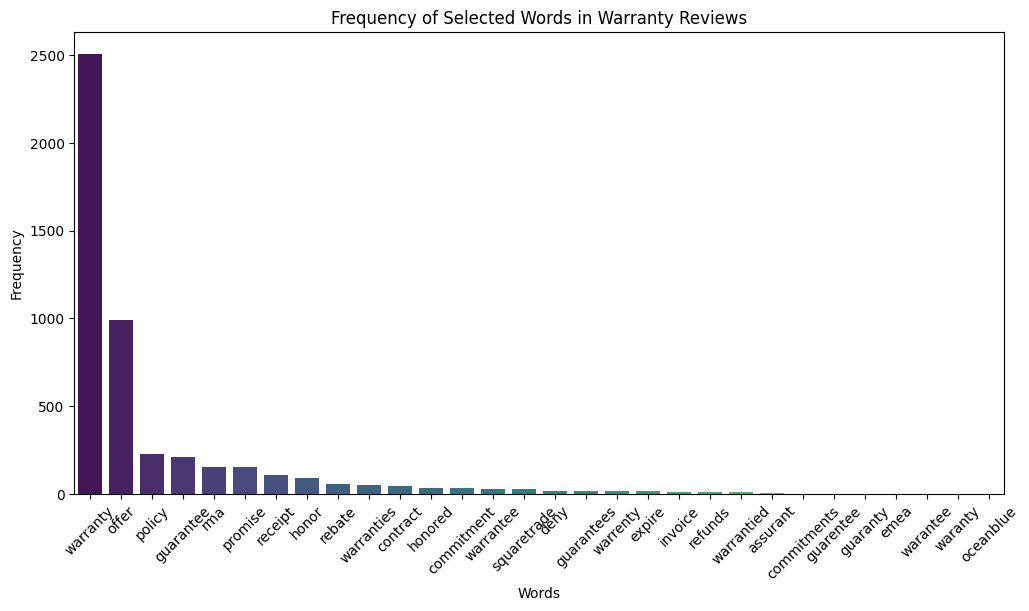

In [210]:
all_text = " ".join(df_warranty_reviews['reviewText'].astype(str).tolist()).lower()

word_counts = Counter()

for word in valid_words:
    pattern = r'\b' + re.escape(word) + r'\b'
    count = len(re.findall(pattern, all_text))
    word_counts[word] = count

sorted_words_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12,6))
sns.barplot(x=list(sorted_words_counts.keys()), y=list(sorted_words_counts.values()), palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency of Selected Words in Warranty Reviews")
plt.show()

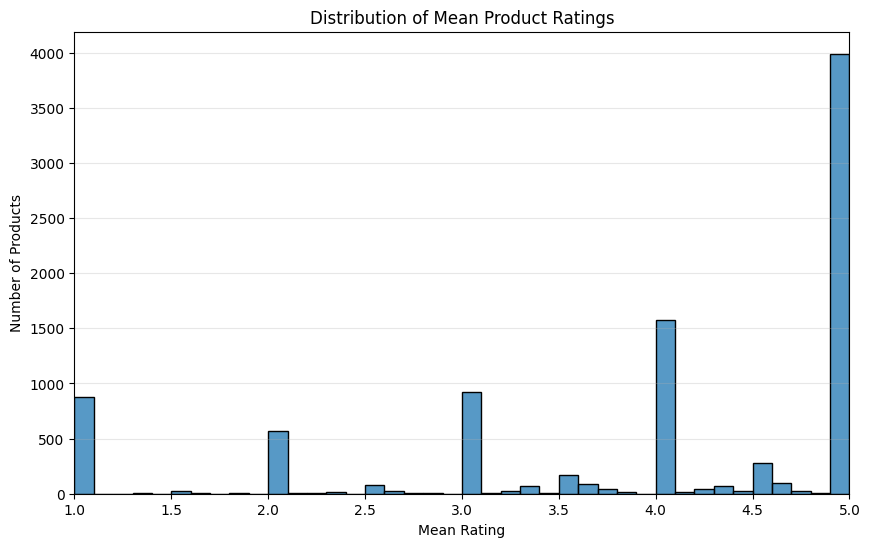

In [216]:
plt.figure(figsize=(10,6))
sns.histplot(review_mean, bins=40, edgecolor='black')

plt.title("Distribution of Mean Product Ratings")
plt.xlabel("Mean Rating")
plt.ylabel("Number of Products")
plt.xlim(1,5)
plt.grid(axis='y', alpha=0.3)
plt.show()